# Criação do Modelo

In [1]:
# Bibliotecas para manipulação e vizualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas de tranformação dos dados
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas para a modelagem estatítica
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

In [3]:
# Carregando os dados
energy_weather = pd.read_csv('sceaux_energy_weather.csv', index_col= "Unnamed: 0")
energy_weather.head()

,Hour,Global_active_power,season,Year,DayOfYear,temp,humidity,precip,preciptype,snowdepth,windspeed,cloudcover
0,0,2.550633,Winter,2007,1,49.9,74.7,0.406,rain,0.0,20.4,75.2
1,1,2.523400,Winter,2007,1,49.9,74.7,0.406,rain,0.0,20.4,75.2
2,2,2.582333,Winter,2007,1,49.9,74.7,0.406,rain,0.0,20.4,75.2
3,3,2.541667,Winter,2007,1,49.9,74.7,0.406,rain,0.0,20.4,75.2
4,4,2.475733,Winter,2007,1,49.9,74.7,0.406,rain,0.0,20.4,75.2


In [4]:
# Obtenha as caracteríticas preditoras
X = energy_weather.drop("Global_active_power", axis= 1)

# Obtenha a coluna de potência elétrica em uma dimensão
y = energy_weather["Global_active_power"]

In [5]:
# Divisão dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

## Engenharia de Características

In [6]:
# Selecione as colunas categoricas
cat_columns = X_train.select_dtypes(include= 'object').columns
cat_columns

Index(['season', 'preciptype'], dtype='object')

In [7]:
# Transforme as categorias em colunas com valores 0 ou 1
cat_encoder = OneHotEncoder(handle_unknown = "ignore")

#energy_cat = X_train[cat_columns]
#energy_cat_encoded = cat_encoder.fit_transform(energy_cat)
#energy_cat_encoded.toarray()[:5]
#cat_encoder.categories_

In [8]:
# Selecione as colunas numéricas
num_columns = X_train.select_dtypes(exclude= 'object').columns
num_columns

Index(['Hour', 'Year', 'DayOfYear', 'temp', 'humidity', 'precip', 'snowdepth',
       'windspeed', 'cloudcover'],
      dtype='object')

In [9]:
# Converta os valores para uma escala entre -1 e 1
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Cria uma sequência de transformação para categorias
cat_pipeline = Pipeline([
    ('cat_encoder', cat_encoder)
])

# Cria uma sequência de transformação para números
num_pipeline = Pipeline([
    ('min_max_scaler', min_max_scaler)
])

# Agrega transformações por colunas e pipelines
preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, cat_columns),
    ('num', num_pipeline, num_columns)
])

In [11]:
# Processamento das entradas de treino
X_train_prepared = preprocessing.fit_transform(X_train)

In [12]:
# Nomes das colunas após o preprocessamento
preprocessing.get_feature_names_out()

array(['cat__season_Autumn', 'cat__season_Spring', 'cat__season_Summer',
       'cat__season_Winter', 'cat__preciptype_rain',
       'cat__preciptype_rain,snow', 'cat__preciptype_nan', 'num__Hour',
       'num__Year', 'num__DayOfYear', 'num__temp', 'num__humidity',
       'num__precip', 'num__snowdepth', 'num__windspeed',
       'num__cloudcover'], dtype=object)

## Escolha do Modelo

In [13]:
# Dicionário com nomes dos algoritmos e modelos repectivos
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR()
}

# Lista com as métricas de resultados
results = []

# Laço com iteração sobre cada modelo
for model in models.values():
  # Separação aleatória dos dados em 4 partes
  kf = KFold(n_splits = 4, random_state = 42, shuffle = True)
  # Lista com o cálculo do erro médio absoluto de forma cruzada
  cv_results = cross_val_score(model, X_train_prepared, y_train, cv = kf,
                               scoring = "neg_mean_absolute_error")
  # Adicione a lista acima aos resultados
  results.append(cv_results)

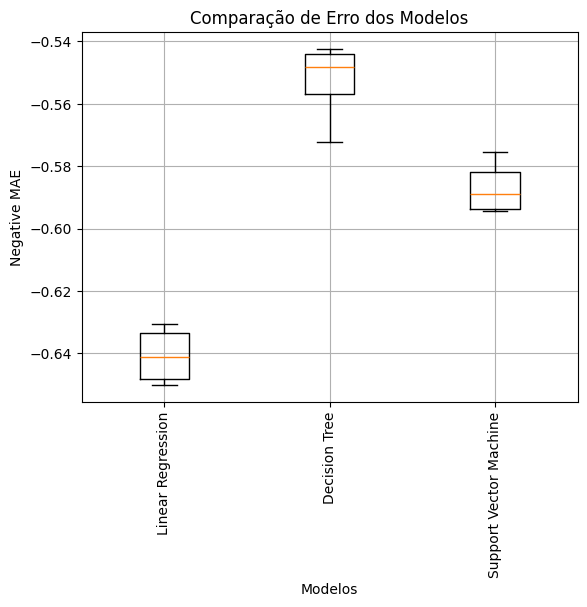

In [14]:
# Exibe um diagrama de caixa para o desempenho de cada modelo
plt.boxplot(results, labels = models.keys())

plt.title("Comparação de Erro dos Modelos")
plt.xlabel("Modelos")
plt.ylabel("Negative MAE")
plt.xticks(rotation = 90)
plt.grid()
plt.show()

O modelo com o melhor desempenho (valores de erro mais próximos à zero) foi o de Árvore de Decisão, com um Erro Médio Absoluto por volta de 0.55. Nesse caso, na tentativa de melhorar as previsões pode-se alterar s hiperparametros do algoritmo.

## Hiperparâmetros

In [15]:
# Dicionário com possíveis hiperparametros para árvore de decisão
param_dist = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['absolute_error'],
    'splitter': ['best', 'random']
}

In [16]:
# Inicializando um novo modelo de Árvore de Decisão
dt_regressor = DecisionTreeRegressor(random_state=42)

In [17]:
# Busca aleatória de um modelo dados os parametros anteriores
random_search = RandomizedSearchCV(
    estimator= dt_regressor,
    param_distributions= param_dist,
    n_iter= 15,     # Número de combinações aleatórias para testar
    cv= 3,          # Número de splits para validação cruzada
    verbose= 2,     # Mais informações à exibir
    random_state= 42,
    n_jobs= -1      # Usa todos os núcleos do processador
)

In [18]:
# Ajustando o RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'criterion': ['absolute_error'],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=42, verbose=2)

In [19]:
# Processamento das entradas de teste
X_test_prepared = preprocessing.transform(X_test)

# Predição do conjunto de teste
y_pred = random_search.best_estimator_.predict(X_test_prepared)

# Cálculo do erro absoluto médio
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.47879603125428477


# Considerações Finais

A métrica aponta que o modelo no momento é relativamente inapropriado para predição, uma vez que os valores das saídas estão próximos a zero e dois. Ainda há espaço para melhoria do projeto, como maior acuidade sobre a engenharia de características e a escolha de modelos mais complexos de ensemble como RandomForestRegressor.

No mais, esses documentos pode demonstrar que é possível indentificar tendências de consumo elétrico durante o ano, e que os mesmos podem estar sucetíveis a variações climáticas. Talvez em uma população de casas, seja mais eficaz identificar essas projeções de energia, mas também, com suporte de profissionais da área para direcionar as necessidades desse campo.